LEGO Catalog Database

Find the data here: https://rebrickable.com/downloads/

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
from scipy.stats import norm, zscore 
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore") 

In [2]:
themes = pd.read_csv('themes.csv.gz')
colors = pd.read_csv('colors.csv.gz')
part_categories = pd.read_csv('part_categories.csv.gz')
parts = pd.read_csv('parts.csv.gz')
part_relationships = pd.read_csv('part_relationships.csv.gz')
elements = pd.read_csv('elements.csv.gz')
sets = pd.read_csv('sets.csv.gz')
minifigs = pd.read_csv('minifigs.csv.gz')
inventories = pd.read_csv('inventories.csv.gz')
inventory_parts = pd.read_csv('inventory_parts.csv.gz')
inventory_sets = pd.read_csv('inventory_sets.csv.gz')
inventory_minifigs = pd.read_csv('inventory_minifigs.csv.gz') 

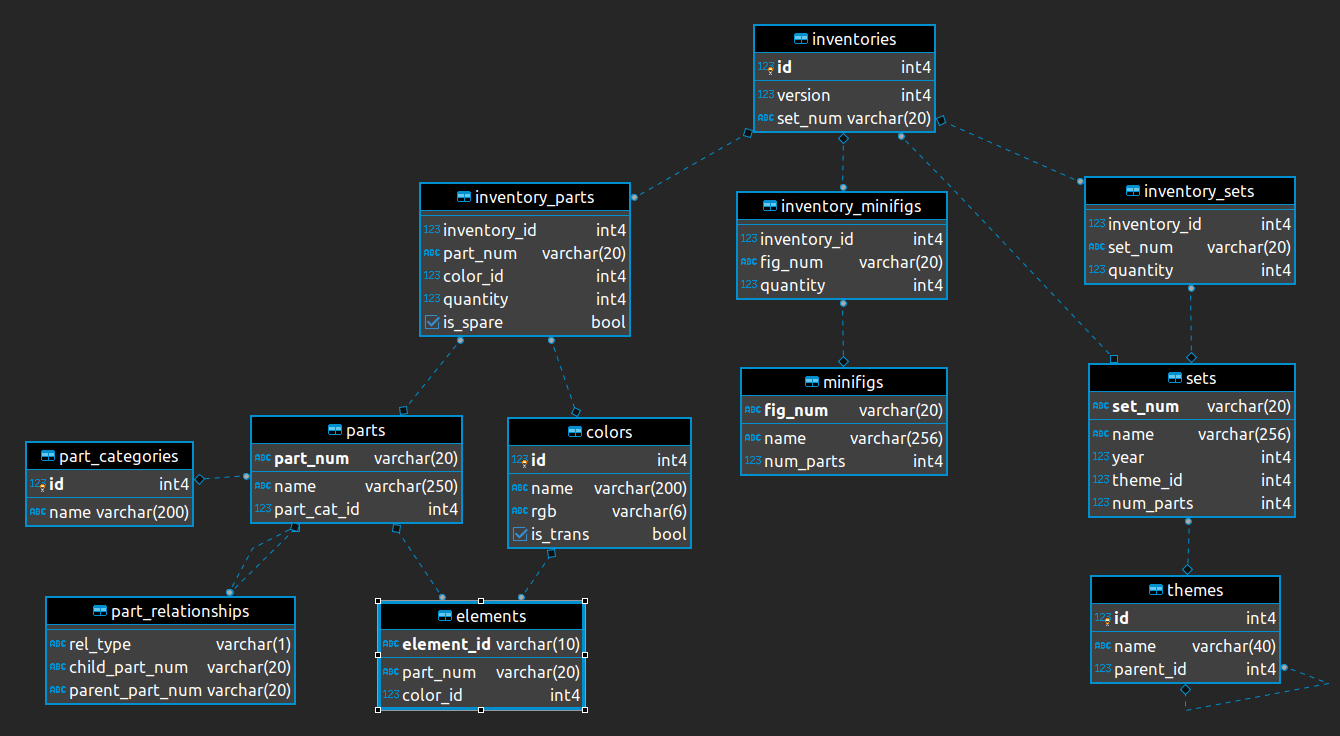

# What is the trend in the number of parts by years? 

In [3]:
sets 

,set_num,name,year,theme_id,num_parts,img_url
0,001-1,Gears,1965,1,43,https://cdn.rebrickable.com/media/sets/001-1.jpg
1,0011-2,Town Mini-Figures,1979,67,12,https://cdn.rebrickable.com/media/sets/0011-2.jpg
2,0011-3,Castle 2 for 1 Bonus Offer,1987,199,0,https://cdn.rebrickable.com/media/sets/0011-3.jpg
3,0012-1,Space Mini-Figures,1979,143,12,https://cdn.rebrickable.com/media/sets/0012-1.jpg
4,0013-1,Space Mini-Figures,1979,143,12,https://cdn.rebrickable.com/media/sets/0013-1.jpg
...,...,...,...,...,...,...
20919,XWING-1,Mini X-Wing Fighter,2019,158,60,https://cdn.rebrickable.com/media/sets/xwing-1...
20920,XWING-2,X-Wing Trench Run,2019,158,52,https://cdn.rebrickable.com/media/sets/xwing-2...
20921,YODACHRON-1,Yoda Chronicles Promotional Set,2013,158,413,https://cdn.rebrickable.com/media/sets/yodachr...
20922,YTERRIER-1,Yorkshire Terrier,2018,598,0,https://cdn.rebrickable.com/media/sets/yterrie...


In [4]:
sets.rename(columns={'name': 'set_name'}, inplace=True) 
sets['year'].value_counts()

2021    1136
2020    1010
2019    1000
2022     968
2018     923
        ... 
1950       6
1949       5
1959       4
1953       4
1960       3
Name: year, Length: 73, dtype: int64

In [5]:
# filters
sets = sets.groupby('year').filter(lambda x: len(x) >= 30) 
sets = sets[sets['num_parts'] != 0] 

In [6]:
sets.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16571 entries, 1 to 20921
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   set_num    16571 non-null  object
 1   set_name   16571 non-null  object
 2   year       16571 non-null  int64 
 3   theme_id   16571 non-null  int64 
 4   num_parts  16571 non-null  int64 
 5   img_url    16571 non-null  object
dtypes: int64(3), object(3)
memory usage: 906.2+ KB


In [7]:
sets.describe() 

,year,theme_id,num_parts
count,16571.000000,16571.000000,16571.000000
mean,2006.198721,409.402933,201.634844
std,14.014452,214.180222,453.232681
min,1955.000000,1.000000,1.000000
25%,1999.000000,228.000000,18.000000
50%,2010.000000,453.000000,55.000000
75%,2017.000000,579.000000,201.000000
max,2023.000000,746.000000,11695.000000


In [8]:
sets_year = sets.groupby('year') 
stats = sets_year['num_parts'].agg(['mean', 'median', 'max']) 
stats 

,mean,median,max
year,,,
1955,12.916667,8.0,59
1958,17.761905,7.0,149
1963,66.823529,74.0,276
1964,45.147059,2.5,253
1966,40.223214,16.5,403
...,...,...,...
2019,270.794076,72.0,4784
2020,290.119015,70.0,9036
2021,350.081794,86.5,11695


In [9]:
sets['decade'] = (sets['year'] // 10) * 10
# removing due to not enough data
sets_decade = sets[(sets['decade'] != 1940)] 

## Trend in LEGO Set Size Over Time - visual 

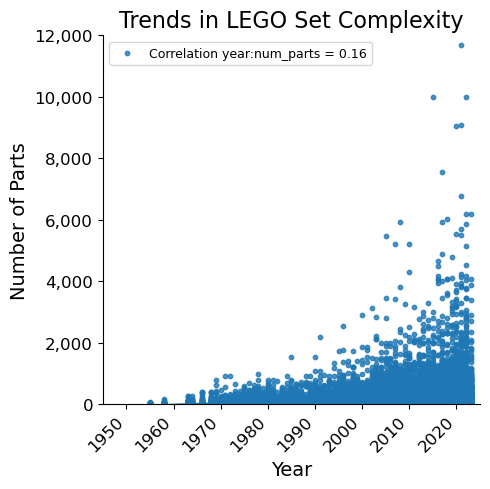

In [10]:
corr = sets['year'].corr(sets['num_parts'])

ax = sns.lmplot(x='year', y='num_parts', data=sets, scatter_kws={"s": 10}) 
ax.set(xlim=(1945, 2025), ylim=(0, 12000))
ax.set_axis_labels("Year", "Number of Parts", fontsize=14)
plt.title(f"Trends in LEGO Set Complexity", fontsize=16)
plt.legend([f'Correlation year:num_parts = {corr:.2f}'], fontsize=9)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show() 

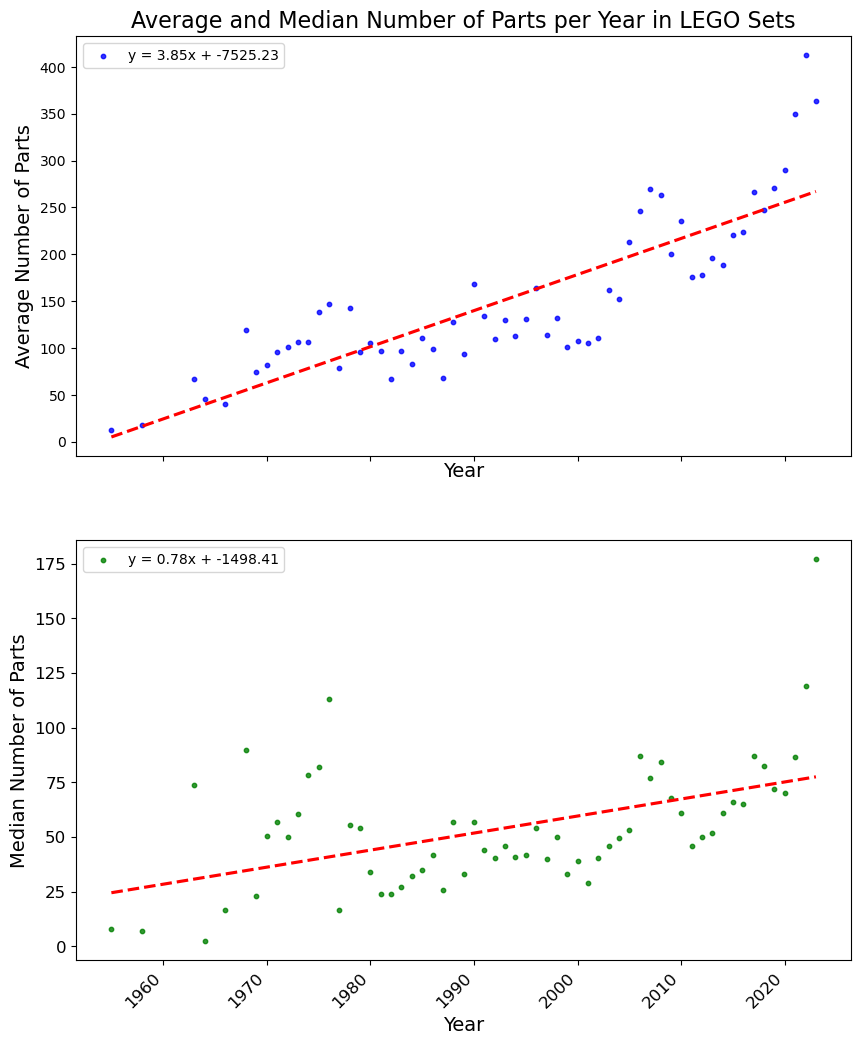

In [11]:
sets_year = sets.groupby('year')
avg_num_parts = sets_year['num_parts'].mean()
median_num_parts = sets_year['num_parts'].median()

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 12), sharex=True)

# regression line mean
sns.regplot(x=avg_num_parts.index, y=avg_num_parts.values, color='blue', 
            ci=None, scatter_kws={"s": 10}, line_kws={"color": "red", "linestyle":"--"}, ax=ax1)
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel('Average Number of Parts', fontsize=14)
ax1.set_title('Average and Median Number of Parts per Year in LEGO Sets', fontsize=16)

# Adding the regression function formula 
slope, intercept = np.polyfit(avg_num_parts.index, avg_num_parts.values, 1)
ax1.legend([f'y = {slope:.2f}x + {intercept:.2f}'])

# regression line median
sns.regplot(x=median_num_parts.index, y=median_num_parts.values, color='green', 
            ci=None, scatter_kws={"s": 10}, line_kws={"color": "red", "linestyle":"--"}, ax=ax2)
ax2.set_xlabel('Year', fontsize=14)
ax2.set_ylabel('Median Number of Parts', fontsize=14)

# Adding the regression function formula 
slope, intercept = np.polyfit(median_num_parts.index, median_num_parts.values, 1)
ax2.legend([f'y = {slope:.2f}x + {intercept:.2f}'])

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

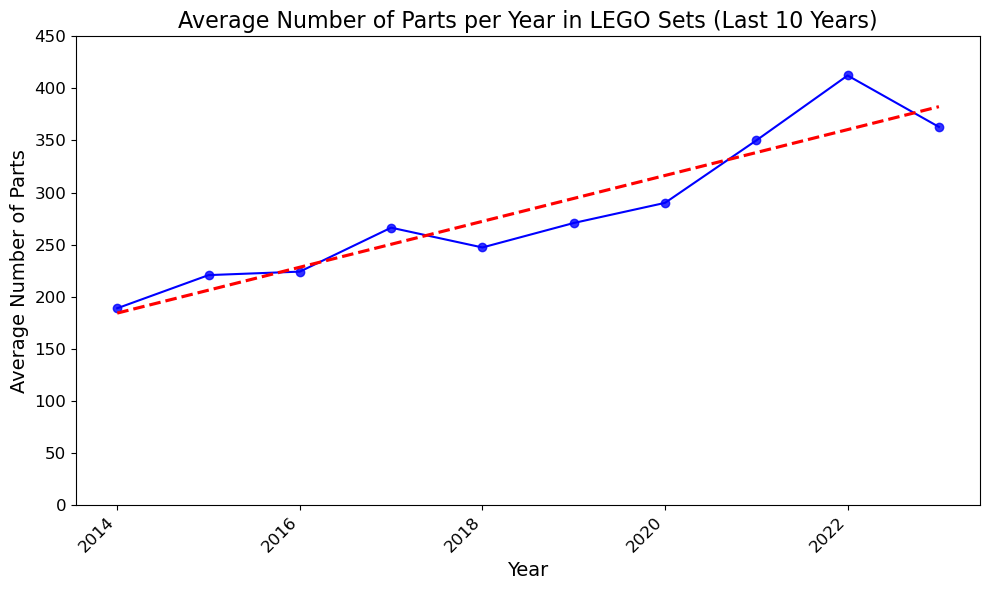

In [12]:
last_10_years = avg_num_parts.tail(10)
plt.figure(figsize=(10, 6))
sns.lineplot(x=last_10_years.index, y=last_10_years.values, color='blue')
sns.regplot(x=last_10_years.index, y=last_10_years.values, ci=None, color='blue', line_kws={"color": "red", "linestyle":"--"})

plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Number of Parts', fontsize=14)
plt.ylim(0, 450)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.title('Average Number of Parts per Year in LEGO Sets (Last 10 Years)', fontsize=16)
plt.tight_layout()
plt.show() 

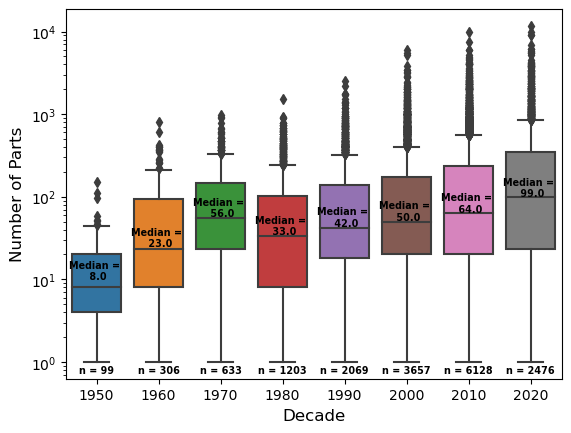

In [13]:
ax = sns.boxplot(data=sets, x='decade', y='num_parts')
plt.yscale('log')
plt.xlabel('Decade', fontsize=12)
plt.ylabel('Number of Parts', fontsize=12)

# median and other relevant data
medians = sets.groupby(['decade'])['num_parts'].median().values
nobs = sets.groupby(['decade']).size().values
nobs = [f'n = {i}' for i in nobs]
pos = range(len(nobs))
for tick, label in zip(pos, ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 2, f'Median = \n {medians[tick]}', 
            horizontalalignment='center', size='x-small', color='black', weight='semibold')
    ax.text(pos[tick], ax.get_ylim()[0] + 0.1, nobs[tick], 
            horizontalalignment='center', size='x-small', color='black', weight='semibold')
 
plt.show() 

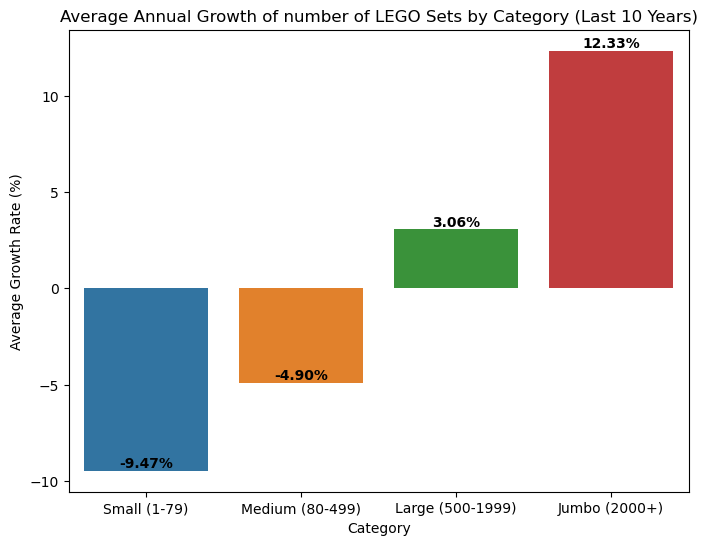

In [14]:
last_10_years = sets[sets['year'] >= sets['year'].max() - 9]

categories = ['Small (1-79)', 'Medium (80-499)', 'Large (500-1999)', 'Jumbo (2000+)']
cat_limits = [(1, 79), (80, 499), (500, 1999), (2000, 10000)]

last_10_years['category'] = pd.cut(last_10_years['num_parts'], 
                                   bins=[0, 79, 499, 1999, 10000], 
                                   labels=categories)
sets_by_cat = last_10_years.groupby(['category', 'year'])['set_num'].nunique().reset_index()

sets_by_cat['pct_change'] = sets_by_cat.groupby('category')['set_num'].pct_change() * 100

avg_growth_rates = sets_by_cat.groupby('category')['pct_change'].mean()

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=categories, y=avg_growth_rates)
plt.xlabel('Category')
plt.ylabel('Average Growth Rate (%)')
plt.title('Average Annual Growth of number of LEGO Sets by Category (Last 10 Years)')

# Add value on each bar
for i, rate in enumerate(avg_growth_rates):
    ax.text(i, rate, f"{rate:.2f}%", ha='center', va='bottom', fontweight='bold')

plt.show()  

## Outliers removed

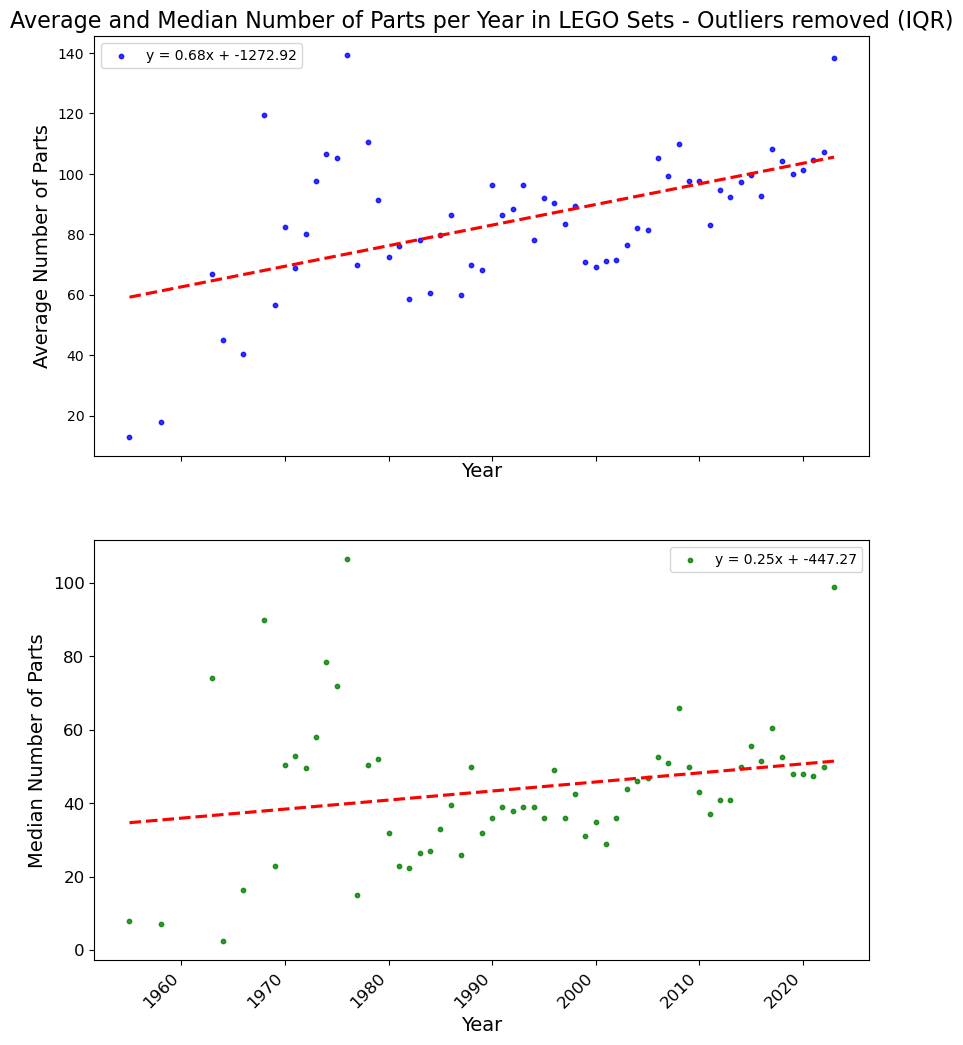

In [15]:
q1 = sets['num_parts'].quantile(0.25)
q3 = sets['num_parts'].quantile(0.75)
iqr = q3 - q1
lower_limit = q1 - 1.5 * iqr
upper_limit = q3 + 1.5 * iqr

# Remove the outliers from the DataFrame
sets_no_outliers = sets[(sets['num_parts'] >= lower_limit) & (sets['num_parts'] <= upper_limit)]

# Group the DataFrame by year and calculate the mean and median number of parts for each year
grouped = sets_no_outliers.groupby('year')
avg_num_parts = grouped['num_parts'].mean()
median_num_parts = grouped['num_parts'].median()

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 12), sharex=True)

# Plot the regression line for the mean number of parts
sns.regplot(x=avg_num_parts.index, y=avg_num_parts.values, color='blue', 
            ci=None, scatter_kws={"s": 10}, line_kws={"color": "red", "linestyle":"--"}, ax=ax1)
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel('Average Number of Parts', fontsize=14)
ax1.set_title('Average and Median Number of Parts per Year in LEGO Sets - Outliers removed (IQR)', fontsize=16)

# Add the regression function formula to the chart legend
slope, intercept = np.polyfit(avg_num_parts.index, avg_num_parts.values, 1)
ax1.legend([f'y = {slope:.2f}x + {intercept:.2f}'])

# Plot the regression line for the median number of parts
sns.regplot(x=median_num_parts.index, y=median_num_parts.values, color='green', 
            ci=None, scatter_kws={"s": 10}, line_kws={"color": "red", "linestyle":"--"}, ax=ax2)
ax2.set_xlabel('Year', fontsize=14)
ax2.set_ylabel('Median Number of Parts', fontsize=14)

# Add the regression function formula to the chart legend
slope, intercept = np.polyfit(median_num_parts.index, median_num_parts.values, 1)
ax2.legend([f'y = {slope:.2f}x + {intercept:.2f}'])

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

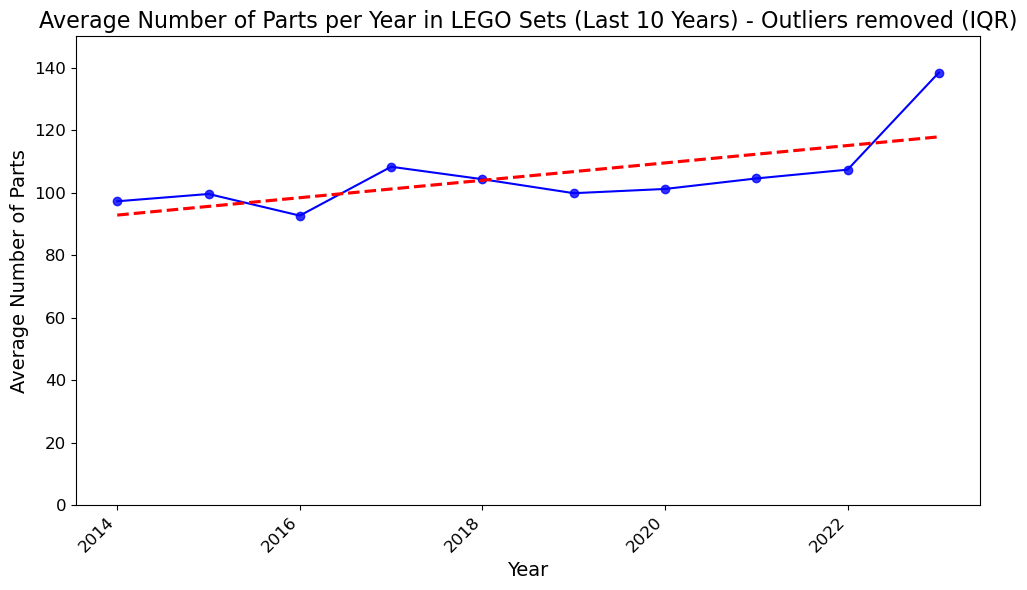

In [16]:
recent_sets = sets_no_outliers[sets_no_outliers['year'] >= 2013]
last_10_years = avg_num_parts.tail(10)

plt.figure(figsize=(10, 6))
sns.lineplot(x=last_10_years.index, y=last_10_years.values, color='blue')
sns.regplot(x=last_10_years.index, y=last_10_years.values, ci=None, color='blue', line_kws={"color": "red", "linestyle":"--"})

plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Number of Parts', fontsize=14)
plt.ylim(0, 150)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.title('Average Number of Parts per Year in LEGO Sets (Last 10 Years) - Outliers removed (IQR)', fontsize=16)
plt.tight_layout()
plt.show() 

# How the number of themes shipped has varied over the years.
Get the number of unique themes released in 1999.

In [17]:
themes.rename(columns={'id': 'theme_id'}, inplace=True)  
themes  

,theme_id,name,parent_id
0,1,Technic,NaN
1,3,Competition,1.0
2,4,Expert Builder,1.0
3,16,RoboRiders,1.0
4,17,Speed Slammers,1.0
...,...,...,...
457,742,Video Games and Accessories,501.0
458,743,Series 24 Minifigures,535.0
459,744,Stuntz,52.0
460,745,Disney 100,535.0


In [18]:
themes.isnull().sum() 

theme_id       0
name           0
parent_id    141
dtype: int64

In [19]:
themes.rename(columns={'name': 'theme_name'}, inplace=True)

# one-to-many relationship between the themes table and the sets table 
sets_with_themes = sets.merge(themes[['theme_id', 'theme_name']], 
                              left_on='theme_id', right_on='theme_id', how='left')

In [20]:
print(len(set(themes.theme_name))) 
print(len(set(themes.theme_id))) 
print(len(set(sets.theme_id))) 

379
462
447


In [21]:
sets_with_themes.isnull().sum() 

set_num       0
set_name      0
year          0
theme_id      0
num_parts     0
img_url       0
decade        0
theme_name    0
dtype: int64

In [22]:
sets_with_themes.columns 

Index(['set_num', 'set_name', 'year', 'theme_id', 'num_parts', 'img_url',
       'decade', 'theme_name'],
      dtype='object')

In [23]:
sets_with_themes.nunique()

set_num       16571
set_name      14041
year             61
theme_id        447
num_parts      1402
img_url       16571
decade            8
theme_name      370
dtype: int64

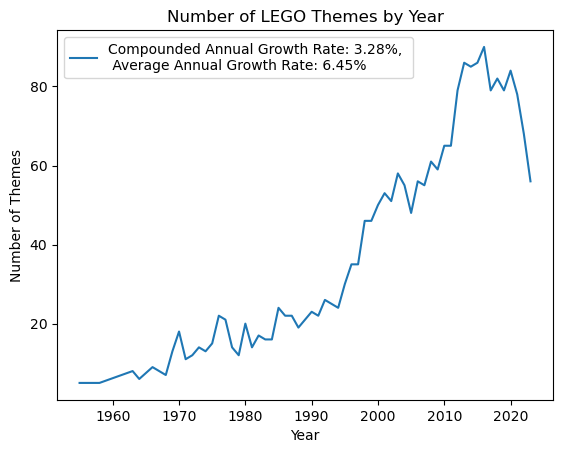

In [24]:
num_themes_by_year = sets_with_themes.groupby('year')['theme_name'].nunique().reset_index()

ax = sns.lineplot(data=num_themes_by_year, x='year', y='theme_name')
plt.xlabel('Year')
plt.ylabel('Number of Themes')
ax.set_title('Number of LEGO Themes by Year')

# using CAGR rate formula
start, end = ax.get_xlim()
growth_rate = (num_themes_by_year['theme_name'].iloc[-1] / 
               num_themes_by_year['theme_name'].iloc[0]) ** (1 / (end - start)) - 1

# using Average Annual Growth Rate formula
annual_rates = ((num_themes_by_year['theme_name'] / num_themes_by_year['theme_name'].shift(1)) - 1).iloc[1:]
avg_annual_rate = annual_rates.mean()

ax.legend(['Compounded Annual Growth Rate: {:.2%}, \n Average Annual Growth Rate: {:.2%}'.format(growth_rate, avg_annual_rate)], loc='upper left')

plt.show() 

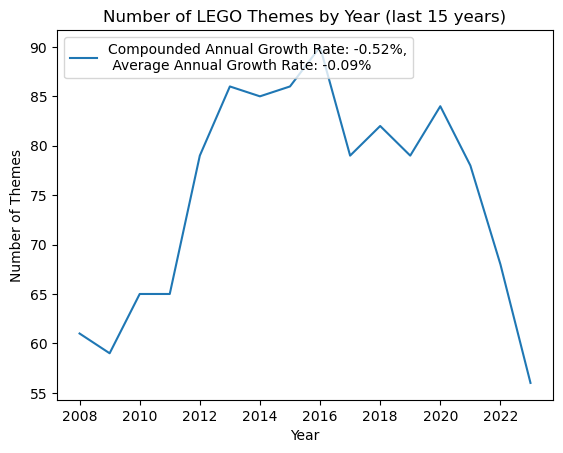

In [25]:
last_15_years = sets_with_themes[sets_with_themes['year'] >= (sets_with_themes['year'].max() - 15)]
num_themes_by_year = last_15_years.groupby('year')['theme_name'].nunique().reset_index()

ax = sns.lineplot(data=num_themes_by_year, x='year', y='theme_name')
plt.xlabel('Year')
plt.ylabel('Number of Themes')
ax.set_title('Number of LEGO Themes by Year (last 15 years)')

# using CAGR rate formula
start, end = ax.get_xlim()
growth_rate = (num_themes_by_year['theme_name'].iloc[-1] / 
               num_themes_by_year['theme_name'].iloc[0]) ** (1 / (end - start)) - 1

# using Average Annual Growth Rate formula
annual_rates = ((num_themes_by_year['theme_name'] / num_themes_by_year['theme_name'].shift(1)) - 1).iloc[1:]
avg_annual_rate = annual_rates.mean()

ax.legend(['Compounded Annual Growth Rate: {:.2%},\n Average Annual Growth Rate: {:.2%}'.format(growth_rate, avg_annual_rate)], loc='upper left')

plt.show() 

In [26]:
# unique themes released in 1999 (first-appeared in 1999) 
# using theme_name because theme_id changes in time 
unique_themes_1999 = sets_with_themes[sets_with_themes.groupby('theme_name')[
                                      'year'].transform('min') == 1999]['theme_name'].unique()
print("The number of unique themes released in 1999 is:", len(unique_themes_1999))
print(unique_themes_1999) 

The number of unique themes released in 1999 is: 13
['Early Creator' 'Advent' 'Space Port' 'Little Forest Friends' 'Jungle'
 'Rock Raiders' 'Stationery and Office Supplies' 'Star Wars'
 'Winnie the Pooh' 'City Center' 'Value Packs' 'Throwbot Slizer' 'eLAB']


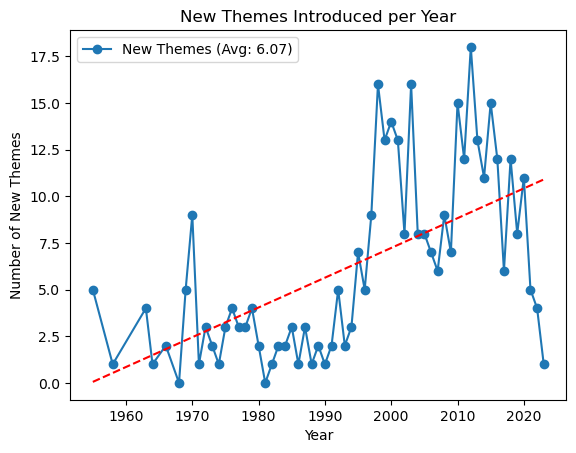

In [27]:
grouped_data = sets_with_themes.groupby('year')['theme_name'].unique()

new_themes = {}
previous_themes = set()

# calculate the number of new themes introduced per year
for y, t in grouped_data.items():
    new_themes[y] = len(set(t) - previous_themes)
    previous_themes.update(t)

years = list(new_themes.keys())
num_new_themes = list(new_themes.values())

average_new_themes = np.mean(num_new_themes)
total_years = len(years)

years_np = np.array(years).reshape(-1, 1)
num_new_themes_np = np.array(num_new_themes).reshape(-1, 1)
regression_line = np.polyfit(years, num_new_themes, 1)
regression_line_fn = np.poly1d(regression_line)

plt.plot(years, num_new_themes, marker='o', linestyle='-')
plt.plot(years, regression_line_fn(years), 'r-', linestyle='--')

plt.xlabel('Year')
plt.ylabel('Number of New Themes')
plt.title('New Themes Introduced per Year')

plt.legend([f'New Themes (Avg: {average_new_themes:.2f})'])
plt.show() 

In [28]:
# checkout
new_themes[1999]  

13

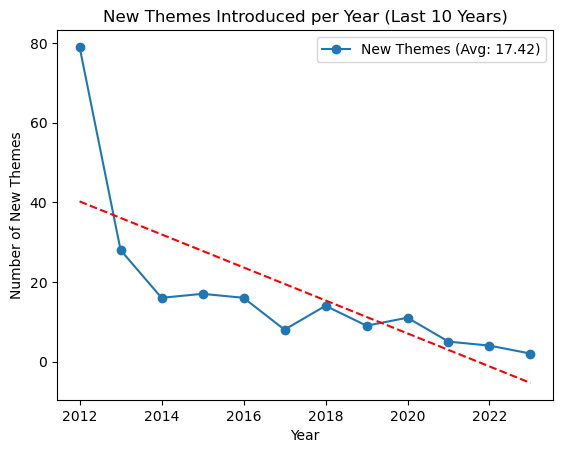

In [29]:
grouped_data = sets_with_themes[sets_with_themes['year'] >= 2012].groupby(
               'year')['theme_name'].unique()

new_themes = {}
previous_themes = set()

for y, t in grouped_data.items():
    new_themes[y] = len(set(t) - previous_themes)
    previous_themes.update(t)

years = list(new_themes.keys())
num_new_themes = list(new_themes.values())

average_new_themes = np.mean(num_new_themes)

years_np = np.array(years).reshape(-1, 1)
num_new_themes_np = np.array(num_new_themes).reshape(-1, 1)
regression_line = np.polyfit(years, num_new_themes, 1)
regression_line_fn = np.poly1d(regression_line)

plt.plot(years, num_new_themes, marker='o', linestyle='-')
plt.plot(years, regression_line_fn(years), 'r-', linestyle='--')

plt.xlabel('Year')
plt.ylabel('Number of New Themes')
plt.title('New Themes Introduced per Year (Last 10 Years)')
plt.legend([f'New Themes (Avg: {average_new_themes:.2f})'])

plt.show() 

# How many distinct colors are available? 
What can you tell us
about how the color scheme changed over the course of the
years? Is there any theme with a single color scheme?

In [30]:
colors.rename(columns={'name': 'color_name', 'id': 'color_id'}, inplace=True)

In [31]:
inventories.rename(columns={'id': 'inventory_id'}, inplace=True)  

In [32]:
inventories.nunique() 

inventory_id    35626
version            16
set_num         34023
dtype: int64

## Number of distinct colors  

In [33]:
colors.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   color_id    218 non-null    int64 
 1   color_name  218 non-null    object
 2   rgb         218 non-null    object
 3   is_trans    218 non-null    object
dtypes: int64(1), object(3)
memory usage: 6.9+ KB


In [34]:
colors.nunique()   

color_id      218
color_name    218
rgb           190
is_trans        2
dtype: int64

In [35]:
# using 'color_name' because some colors cannot be described directly with 'rgb' (e.g. transparent col)
distinct_colors_num = len(colors['color_name'].unique()) 
distinct_colors_list = colors['color_name'].unique() 
# including '[No Color/Any Color]' as a color
print(f"Number of distinct colors: {distinct_colors_num}")  

Number of distinct colors: 218


## Color scheme change over the years 

In [36]:
# Mergeing data from different dataframes using common columns
color_year_theme = pd.merge(
    pd.merge(
        pd.merge(
            sets_with_themes, inventories, on='set_num', how='left'
        ), inventory_parts, on='inventory_id', how='left'
    ), colors, on='color_id', how='left'
) 

In [37]:
color_year_theme.nunique() 

set_num         16571
set_name        14041
year               61
theme_id          447
num_parts        1402
img_url_x       16571
decade              8
theme_name        370
inventory_id    17951
version            16
part_num        33695
color_id          203
quantity          378
is_spare            2
img_url_y       54718
color_name        203
rgb               183
is_trans            2
dtype: int64

In [38]:
cyt = color_year_theme.copy() 
cyt = color_year_theme.loc[:, ['year', 'theme_id', 'decade', 'theme_name', 'color_id', 'color_name']]

In [39]:
cyt.dropna(subset=['color_name'], inplace=True)
cyt.nunique() 

year           61
theme_id      446
decade          8
theme_name    370
color_id      203
color_name    203
dtype: int64

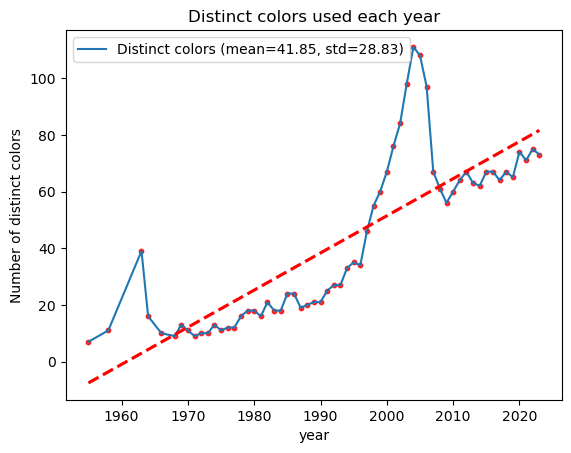

In [40]:
color_per_year = cyt.groupby(['year'])['color_name'].nunique()
mean_colors = np.mean(color_per_year.values)
std_colors = np.std(color_per_year.values)

plt.plot(color_per_year.index, color_per_year.values, label=f'Distinct colors (mean={mean_colors:.2f}, std={std_colors:.2f})')
plt.xlabel('Year')
plt.ylabel('Number of distinct colors')
plt.title('Distinct colors used each year')

sns.regplot(x=color_per_year.index, y=color_per_year.values, 
            color='red', ci=None, scatter_kws={"s": 10}, line_kws={"color": "red", "linestyle":"--"})

plt.legend()
plt.show() 

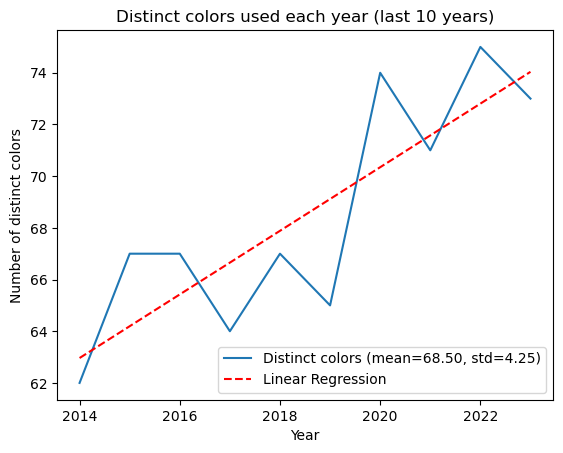

In [41]:
last_10_years = color_per_year.tail(10)

mean_colors = np.mean(last_10_years.values)
std_colors = np.std(last_10_years.values)

plt.plot(last_10_years.index, last_10_years.values, label=f'Distinct colors (mean={mean_colors:.2f}, std={std_colors:.2f})')

x = np.array(last_10_years.index).reshape((-1, 1))
y = np.array(last_10_years.values)
model = LinearRegression().fit(x, y)
y_pred = model.predict(x)
plt.plot(x, y_pred, color='red', label='Linear Regression', linestyle='--')

plt.xlabel('Year')
plt.ylabel('Number of distinct colors')
plt.title('Distinct colors used each year (last 10 years)')

plt.legend()
plt.show() 

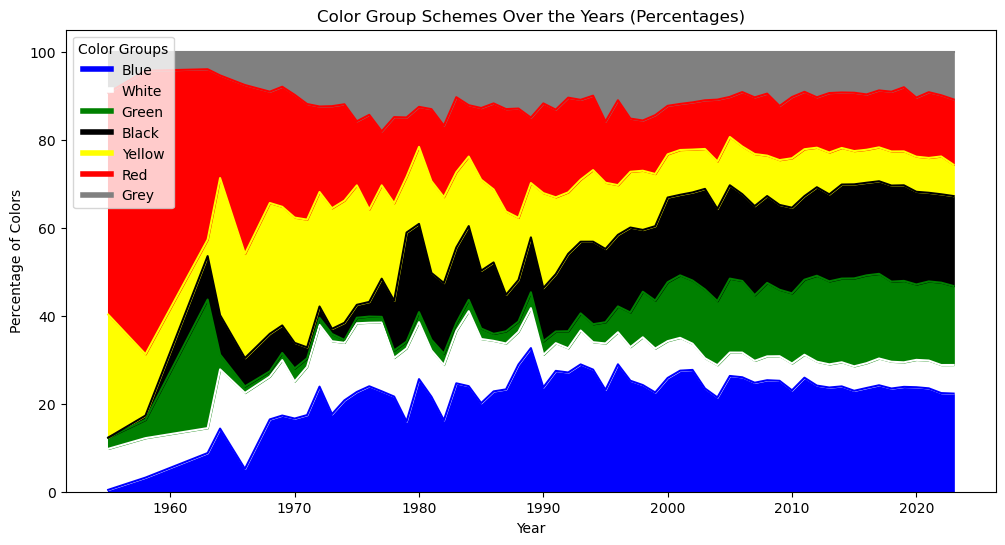

  cluster                                         color_name
0   Black  [Black, Dark Green, Reddish Brown, Brown, Dark...
1    Blue  [Blue, Trans-Dark Blue, Dark Purple, Medium Bl...
2   Green  [Green, Dark Bluish Gray, Pearl Gold, Trans-Bl...
3    Grey  [Light Gray, Light Bluish Gray, Bright Pink, T...
4     Red  [Trans-Red, Red, Dark Red, Dark Orange, Rust, ...
5   White  [White, Trans-Clear, Milky White, Trans-Light ...
6  Yellow  [Yellow, Trans-Yellow, Trans-Orange, Fabuland ...


In [42]:
"""This code performs K-means clustering on a dataset of color values represented in RGB format,
assigns each color to one of 7 color groups, and then plots the distribution of color groups over
time as stacked area charts. The distinct color names in each of the 7 color groups are then printed."""

from sklearn.cluster import KMeans
import matplotlib.colors as mcolors

#  missing / invalid rgb 
color_year_theme = color_year_theme[color_year_theme['rgb'].apply(
                   lambda x: isinstance(x, str) and len(x) == 6)]

# hexadecimal to decimal rgb
def hex_to_dec(hex_value):
    return tuple(int(hex_value[i:i+2], 16) for i in (0, 2, 4))

color_year_theme['rgb_decimal'] = color_year_theme['rgb'].apply(hex_to_dec)
rgb_values = np.array(color_year_theme['rgb_decimal'].tolist())

# K-means
num_clusters = 7
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(rgb_values)
color_year_theme['cluster'] = kmeans.labels_

cluster_names_colors = {0: ('Blue', 'blue'), 1: ('White', 'white'), 
                        2: ('Green', 'green'), 3: ('Black', 'black'), 
                        4: ('Yellow', 'yellow'), 5: ('Red', 'red'), 6: ('Grey', 'grey')}
color_year_theme['cluster'] = color_year_theme['cluster'].map(lambda x: cluster_names_colors[x][0])
color_groups_by_year = color_year_theme.groupby(['year', 'cluster'])['rgb'].count().reset_index()
color_groups_by_year = color_groups_by_year.sort_values(['year', 'cluster'])

# using the logic of having a cetain color in set, not focusing on quantity and number
# Pivot 
color_groups_pivot = color_groups_by_year.pivot_table(
                     index='year', columns='cluster', values='rgb', fill_value=0)

# Normalize for percentages
color_groups_pivot_normalized = color_groups_pivot.div(
                                color_groups_pivot.sum(axis=1), axis=0) * 100

# Extract color
color_names_list = [name for name, color in cluster_names_colors.values()]
colors_list = [color for name, color in cluster_names_colors.values()]
custom_colormap = mcolors.ListedColormap(colors_list)

ax = color_groups_pivot_normalized.plot(kind='area', stacked=True, 
                                        figsize=(12, 6), colormap=custom_colormap)
plt.xlabel('Year')
plt.ylabel('Percentage of Colors')
plt.title('Color Group Schemes Over the Years (Percentages)')

legend_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in colors_list]
ax.legend(legend_handles, color_names_list, title='Color Groups', loc='upper left')
plt.show() 

# distinct color names in each cluster
color_names_by_cluster = color_year_theme.groupby('cluster')['color_name'].unique().reset_index()
print(color_names_by_cluster) 

## Theme with a single color scheme?

### Theme with One color  

In [43]:
color_per_theme = color_year_theme.groupby(['theme_name'])['color_name'].nunique()
single_color_theme = color_per_theme[color_per_theme == 1]

# Print 'theme_name' if theme follows a single color scheme
if len(single_color_theme) > 0:
    print("The following 'theme_name' have a single color scheme:")
    for theme_name in single_color_theme.index:
        print("-> " + theme_name)
else:
    print("There are no 'theme_name' with a single color scheme in the DataFrame.")

The following 'theme_name' have a single color scheme:
-> DFB Minifigures
-> Value Packs


In [44]:
color_per_theme.sort_values() 

theme_name
Value Packs                 1
DFB Minifigures             1
Audio and Visual Media      2
Power Functions             4
Rattles                     4
                         ... 
Star Wars                  78
Creator                    79
Belville                   85
Harry Potter               91
Database Sets             111
Name: color_name, Length: 370, dtype: int64

In [45]:
color_year_theme[color_year_theme["theme_name"] == "DFB Minifigures"].head() 

,set_num,set_name,year,theme_id,num_parts,img_url_x,decade,theme_name,inventory_id,version,part_num,color_id,quantity,is_spare,img_url_y,color_name,rgb,is_trans,rgb_decimal,cluster
676325,71014-1,Joachim Löw,2016,557,6,https://cdn.rebrickable.com/media/sets/71014-1...,2010,DFB Minifigures,10364,1,3068bpr0298,15.0,1.0,f,https://cdn.rebrickable.com/media/parts/elemen...,White,FFFFFF,f,"(255, 255, 255)",White
676326,71014-1,Joachim Löw,2016,557,6,https://cdn.rebrickable.com/media/sets/71014-1...,2010,DFB Minifigures,10364,1,88646pr0002,15.0,1.0,f,https://cdn.rebrickable.com/media/parts/elemen...,White,FFFFFF,f,"(255, 255, 255)",White
676327,71014-10,Toni Kroos (18),2016,557,6,https://cdn.rebrickable.com/media/sets/71014-1...,2010,DFB Minifigures,13846,1,26562,15.0,1.0,f,https://cdn.rebrickable.com/media/parts/elemen...,White,FFFFFF,f,"(255, 255, 255)",White
676328,71014-10,Toni Kroos (18),2016,557,6,https://cdn.rebrickable.com/media/sets/71014-1...,2010,DFB Minifigures,13846,1,88646pr0002,15.0,1.0,f,https://cdn.rebrickable.com/media/parts/elemen...,White,FFFFFF,f,"(255, 255, 255)",White
676329,71014-11,Sami Khedira (6),2016,557,6,https://cdn.rebrickable.com/media/sets/71014-1...,2010,DFB Minifigures,7006,1,26562,15.0,1.0,f,https://cdn.rebrickable.com/media/parts/elemen...,White,FFFFFF,f,"(255, 255, 255)",White


### Theme with constant color combination through years 

In [46]:
# f returns a comma-separated string of unique color names sorted in alphabetical order
def get_color_scheme(df):
    color_names = df['color_name']
    if not all(isinstance(c, str) for c in color_names):
        color_names = color_names.astype(str)
    return ','.join(sorted(color_names.unique().tolist()))

color_scheme_group = color_year_theme.groupby(['year', 'theme_name']).apply(
               get_color_scheme).reset_index(name='color_scheme')
color_scheme_group

,year,theme_name,color_scheme
0,1955,Database Sets,White
1,1955,HO 1:87 Vehicles,"Blue,Red,White,Yellow"
2,1955,Supplemental,"Blue,Green,Red,Trans-Clear,White,Yellow"
3,1955,System,"Blue,Red,White,Yellow"
4,1955,Town Plan,"Red,White,[No Color/Any Color]"
...,...,...,...
2313,2023,Super Mario,"Black,Blue,Bright Green,Bright Light Blue,Brig..."
2314,2023,Technic,"Black,Blue,Bright Green,Bright Light Orange,Da..."
2315,2023,Town,"Black,Bright Green,Bright Light Orange,Bright ..."
2316,2023,Traffic,"Black,Blue,Dark Blue,Dark Bluish Gray,Flat Sil..."


In [47]:
theme_schemes = color_scheme_group.groupby('theme_name').agg({'color_scheme': 'nunique', 'year': 'nunique'})
theme_schemes  

,color_scheme,year
theme_name,,
12V,8,10
4 Juniors,2,2
4.5V,9,13
9V,13,13
Action Wheelers,2,2
...,...,...
X-Pod,3,3
Xtra,4,4
Znap,1,2


In [48]:
theme_schemes.columns = ['distinct_color_schemes', 'distinct_years']
theme_schemes.loc[(theme_schemes['distinct_color_schemes'] == 1) 
                  & (theme_schemes['distinct_years'] > 1)]

,distinct_color_schemes,distinct_years
theme_name,,
M:Tron,1,2
Soft Bricks,1,4
Znap,1,2


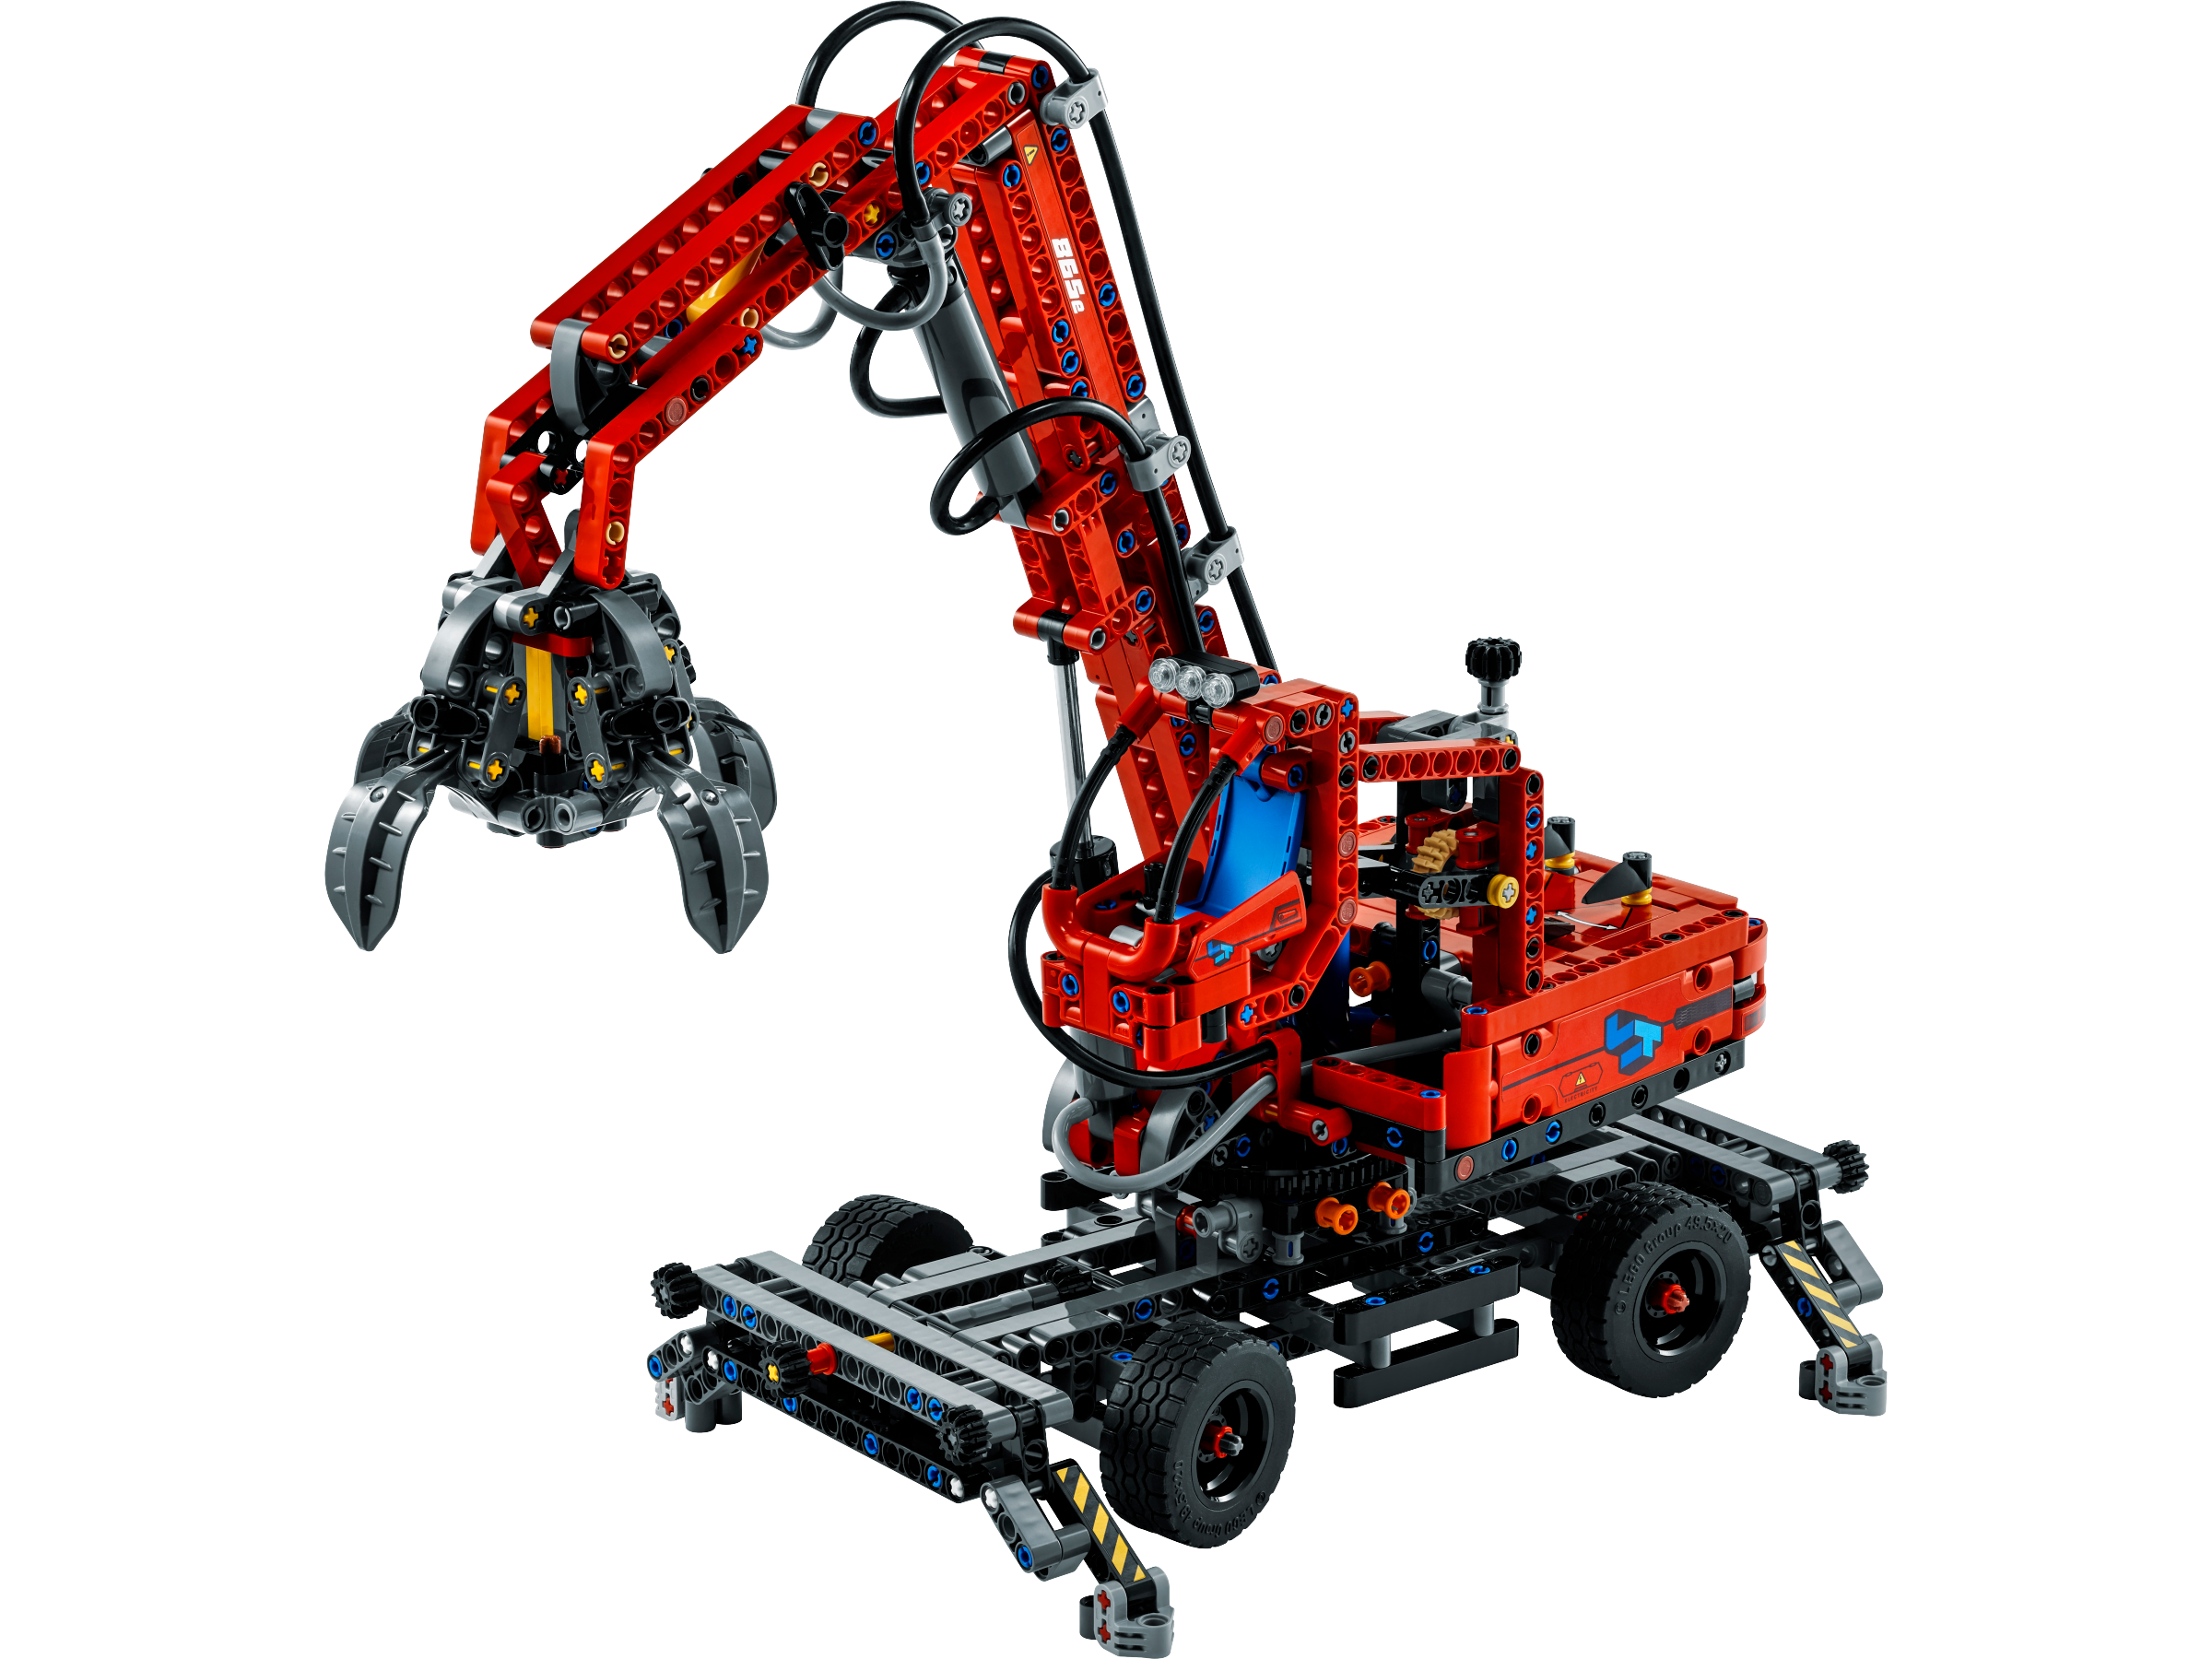

# CONCLUSION

1)
What is the trend in the number of parts by years?


Key Observations:

- The trend in the number of parts by years is rising throughout the history, where historical data shows the significant increase in the number of parts today and in the past century! 
- Looking at the Average and Median Number of Parts, it is visible that the Average had a higher growth rates. 
- Even the analysis of most recent period shows that in the 10-years period the number of parts can double in quantity. 
- There is a constant rise of sets with exceptionally high parts quantity each decade (categories of Jumbo and Large had the positive Average Annual Growth of number of LEGO Sets by Category in the Last 10 Years), while Small and Medium had negative growth rates.

Conclusion:

- After removing outliers, both the average and median number of parts continue to grow (throughout history and particularly in the last 10 years), but at a more similar rate. 
- This leads us to conclude that the upward trend is not solely driven by the popularity of exceptionally large sets.

2)
How the number of themes shipped has varied over the years?
Get the number of unique themes released in 1999!

Key Observations:
- The total number of themes in LEGO sets has had a constant growth over the years until reaching a peak in 2016. Since then, the number has started to drop, followed by a drop in the number of new themes introduced per year as well.
- As of today, the number of themes is very close to the number 15 years ago.
- In 1999, there were 13 unique themes released.

Conclusion:
- Reducing New Themes Introduction has additionally boosted the drop in total number of LEGO themes
- It is visible that LEGO Group has a long history of innovation and crisis adaptation to changing market trends 

3) 
How many distinct colors are available? 
What can you tell us about how the color scheme changed over the course of the years? 
Is there any theme with a single color scheme?


Key Observations:
- Number of distinct colors is 218 counting '[No Color/Any Color]' as 1 color, and the used color scheme have been growing with two significant peaks visible on a 'Distinct colors used each year' chart. However in the 'Distinct colors used each year (last 10 years)' chart the Regression line shows continuation of significant growth trends. 
- On the 'Color Group Schemes Over the Years (Percentages)' chart we can notice how 7 groups of color clusters have been popular in sets through the history, with Yellow and White cluster getting less popular.
- The following 'theme_name' have a single color scheme:
-> DFB Minifigures
-> Value Packs

Conclusion: 

- The identification of popular color clusters could also inform future product development decisions, allowing the LEGO Group to create sets with colors that are proven to be popular among customers
- Understanding the reasoning behind "single color scheme" design choices could provide insights into the LEGO Group's product development and growth strategies